# German License Plate Data
    
In this project, you will be tasked with building a plagiarism detector that examines a text file and performs binary classification; labeling that file as either plagiarized or not, depending on how similar the text file is when compared to a provided source text.
    
    
The first step in working with any dataset is loading the data in and noting what information is included in the dataset. This is an important step in eventually working with this data, and knowing what kinds of features you have to work with as you transform and group the data!

So, this notebook is all about exploring the data and noting patterns about the features you are given and the distribution of data.

In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import json
import os.path
import random
import re
import time
import cv2
import requests
import pandas as pd
import progressbar

from imutils import paths
from PIL import Image

from config import config

In [2]:
!pygmentize config/config.py

# import the necessary packages
import os

# root paths
DATASET_ROOT_PATH = "data"
SUN397_TAR_FILE = "SUN397.tar.gz"

# network image size
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 64

# training parameter
BATCH_SIZE = 64
NUM_EPOCHS = 1000

# license number construction
DOWNSAMPLE_FACTOR = 2 ** 2  # <= pool size ** number of pool layers
MAX_TEXT_LEN = 10

# model name
MODEL_NAME = "glpr-model"

# supported optimizer methods: sdg, rmsprop, adam, adagrad, adadelta
OPTIMIZER = "adagrad"

# define the path to the output directory used for storing plots, classification reports, etc.
OUTPUT_PATH = "output"
DOCUMENTATION_PATH = "documentation"

# json file with the list of german county marks
GERMAN_COUNTY_MARKS = os.path.join(DATASET_ROOT_PATH, "counties.json")

# define the paths to the training and validation directories
PLATE_IMAGES = os.path.join(DATASET_ROOT_PATH, "images")
TEST_IMAGES = "testimages"

# define the path to the output training, validation, and testing HDF5 files
GLP_HDF5 = os.path

Erläuterung Aufbau deutscher Autokennzeichen...

* Bundesländer
* TÜV-Plakette (Monat/Jahr)
* Front- und Heck-Kennzeichen


16 Bundesländer...


Autokennzeichen: https://laenderkennzeichen.net/deutsche-autokennzeichen/

download Autokennzeichen: https://laenderkennzeichen.net/wp-content/uploads/18-KFZ-Deutschland-2017-06-20.csv

In [3]:
states_df = pd.read_json("data/german_states.json")
print (states_df)

    CM                   DESCR
0   BE                  Berlin
1   BB             Brandenburg
2   BW       Baden-Württemberg
3   BY                  Bayern
4   HB                  Bremen
5   HH                 Hamburg
6   HE                  Hessen
7   MV  Mecklenburg-Vorpommern
8   NI           Niedersachsen
9   NW     Nordrhein-Westfalen
10  RP         Rheinland-Pfalz
11  SH      Schleswig-Holstein
12  SL                Saarland
13  SN                 Sachsen
14  ST          Sachsen-Anhalt
15  TH               Thüringen


In [4]:
states_dict = states_df.set_index('DESCR').to_dict()['CM']

counties_df = pd.read_csv("data/KFZ-Deutschland-2017-06-20.csv", delimiter=';')

counties_df['Autokennzeichen'] = counties_df['Autokennzeichen'].str.replace('*','')
counties_df['Bundesland'] = counties_df['Bundesland'].str.split(' ').str[0]

counties_df.insert(1,'State', counties_df['Bundesland'].replace(states_dict))

counties_df.head(30)

,Autokennzeichen,State,Stadt/Ort,Landkreis/Gemeinde,Bundesland
0,A,BY,Augsburg,Stadt & Landkreis Augsburg,Bayern
1,AA,BW,Aalen,Ostalbkreis,Baden-Württemberg
2,AB,BY,Aschaffenburg,Landkreis & Stadt Aschaffenburg,Bayern
3,ABG,TH,Altenburg,Landkreis Altenburger Land,Thüringen
4,ABI,ST,Anhalt-Bitterfeld,Landkreis Anhalt-Bitterfeld,Sachsen-Anhalt
5,AC,NW,Aachen,Städteregion Aachen,Nordrhein-Westfalen
6,AE,SN,Auerbach im Vogtland,Vogtlandkreis,Sachsen
7,AH,NW,Ahaus,Kreis Borken,Nordrhein-Westfalen
8,AIB,BY,Bad Aibling,Landkreise München & Rosenheim,Bayern
9,AIC,BY,Aichach,Landkreis Aichach-Friedberg,Bayern


In [15]:
class GermanLicensePlateImagesGenerator:
    def __init__(self, counties_df, output_folder):
        self.output_folder = output_folder
        self.counties_df = counties_df
        self.LETTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZÄÖÜ"
        self.DIGITS = "0123456789"
        self.MONTHS = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
        self.YEARS = ['06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17']

        random.seed()

    @staticmethod
    def get_image_url(license_number, state, month, year):
        license_number = license_number.replace("-", "%3A").replace("Ä", "%C4").replace("Ö", "%D6").replace("Ü", "%DC")
        return "http://nummernschild.heisnbrg.net/fe/task?action=startTask&kennzeichen={0}&kennzeichenZeile2=&engschrift=false&pixelHoehe=32&breiteInMM=520&breiteInMMFest=true&sonder=FE&dd=01&mm=01&yy=00&kreis={1}&kreisName=&humm={2}&huyy={3}&sonderKreis=LEER&mm1=01&mm2=01&farbe=SCHWARZ&effekt=KEIN&tgaDownload=false".format(
            license_number, state, month, year)

    def generate_license_number(self, county):
        letter_count = random.randint(1, 2)
        letters = "{}".format(random.choice(self.LETTERS)) if letter_count == 1 else "{}{}".format(
            random.choice(self.LETTERS), random.choice(self.LETTERS))

        min = 1 if letter_count == 2 else 1
        digit_count = random.randint(min, max((8 - len(county) - letter_count), 4))
        digits = ""
        for i in range(digit_count):
            digits += random.choice(self.DIGITS)

        return "{}-{}{}".format(county, letters, digits)

    def create_license_plate_image(self, license_number, state, front):
        file_path = os.path.join(self.output_folder, '{0}#{1}.png'.format("F" if front else "R", license_number))
        if os.path.exists(file_path):
            return False

        month = random.choice(self.MONTHS) if front else ''
        year = random.choice(self.YEARS) if front else ''

        create_image_url = GermanLicensePlateImagesGenerator.get_image_url(license_number, state, month, year)
        r = requests.get(create_image_url)
        if r.status_code != 200:
            return False

        id = re.compile('<id>(.*?)</id>', re.DOTALL | re.IGNORECASE).findall(
            r.content.decode("utf-8"))[0]

        status_url = 'http://nummernschild.heisnbrg.net/fe/task?action=status&id=%s' % id
        time.sleep(.200)
        r = requests.get(status_url)
        if r.status_code != 200:
            return False

        show_image_url = 'http://nummernschild.heisnbrg.net/fe/task?action=showInPage&id=%s'
        show_image_url = show_image_url % id
        time.sleep(.200)
        r = requests.get(show_image_url)
        if r.status_code != 200:
            return False

        # sometimes the web service returns a corrupted image, check the image by getting the size and skip if corrupted
        try:
            numpyarray = np.frombuffer(r.content, dtype=np.uint8)
            image = cv2.imdecode(numpyarray, cv2.IMREAD_COLOR)
            return Image.fromarray(image)  # don't use cv2.imwrite() because there is a bug with utf-8 encoded filepaths
        except:
            return None

    def generate(self, items):
        for n in range(items):
            while True:
                sample = self.counties_df.sample(1)                
                county = sample.Autokennzeichen.values[0]
                state  = sample.State.values[0]

                license_number = self.generate_license_number(county)
               
                file_name = '{0}#{1}.png'.format("F", license_number)
                file_path = os.path.join(self.output_folder, file_name)
                if os.path.exists(file_path):
                    continue
                
                image = self.create_license_plate_image(license_number, state, True)
                image = image.convert('L')
                if not image is None:
                    image.save(file_path)
                    print("{0:06d} : {1}".format(n+1, file_name))

                time.sleep(.200)

                file_name = '{0}#{1}.png'.format("R", license_number)
                file_path = os.path.join(self.output_folder, file_name)
                if os.path.exists(file_path):
                    continue

                image = self.create_license_plate_image(license_number, state, False)
                image = image.convert('L')
                if not image is None:
                    image.save(file_path)
                    print("{0:06d} : {1}".format(n+1, file_name))

                time.sleep(.200)
                break

                
lpig = GermanLicensePlateImagesGenerator(counties_df, "data/plate_images")

County:  BI
State:   NW
License: BI-JG033


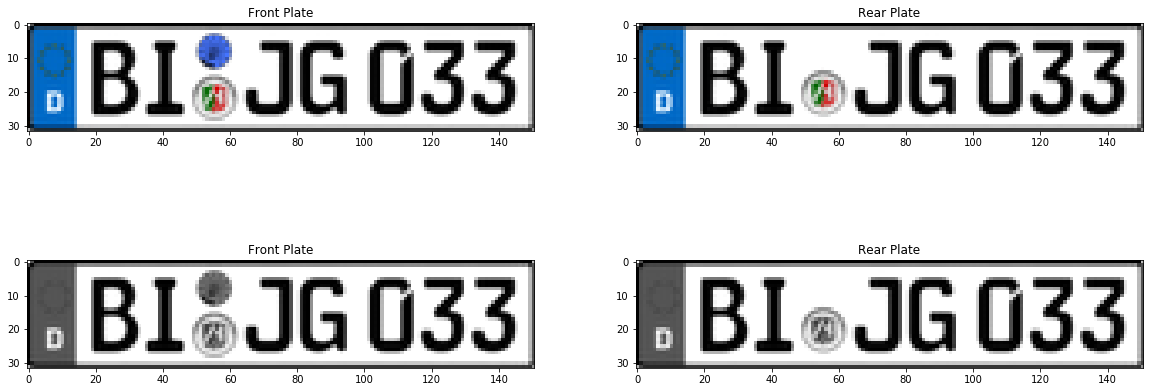

In [17]:
def generate_plate_images():
    sample = lpig.counties_df.sample(1)           
    county = sample.Autokennzeichen.values[0]
    state  = sample.State.values[0]

    print ("County:  {}".format(county))
    print ("State:   {}".format(state))
 
    license_number = lpig.generate_license_number(county)
    print ("License: {}".format(license_number))

    front_image = lpig.create_license_plate_image(license_number, state, True)
    rear_image = lpig.create_license_plate_image(license_number, state, False)
    return np.array(front_image), np.array(rear_image)
    

fig=plt.figure(figsize=(20, 8))

front_image, rear_image = generate_plate_images()
ax = fig.add_subplot(2,2,1)
plt.imshow(cv2.cvtColor(front_image, cv2.COLOR_BGR2RGB))
ax.set_title("Front Plate")
ax =fig.add_subplot(2,2,2)
plt.imshow(cv2.cvtColor(rear_image, cv2.COLOR_BGR2RGB))
ax.set_title("Rear Plate")

ax = fig.add_subplot(2,2,3)
plt.imshow(cv2.cvtColor(front_image, cv2.COLOR_BGR2GRAY), cmap="gray")
ax.set_title("Front Plate")
ax = fig.add_subplot(2,2,4)
plt.imshow(cv2.cvtColor(rear_image, cv2.COLOR_BGR2GRAY), cmap="gray")
ax.set_title("Rear Plate")

plt.show()

In [18]:
os.makedirs("data/plate_images", exist_ok=True)

lpig.generate(30)

000001 : F#SFT-RA1.png
000001 : R#SFT-RA1.png
000002 : F#B-A7.png
000002 : R#B-A7.png
000003 : F#BÜZ-ÖR7513.png
000003 : R#BÜZ-ÖR7513.png
000004 : F#SEB-V6632.png
000004 : R#SEB-V6632.png
000005 : F#KS-PO55.png
000005 : R#KS-PO55.png
000006 : F#OSL-H4.png
000006 : R#OSL-H4.png
000007 : F#HIP-B19.png
000007 : R#HIP-B19.png
000008 : F#FI-X45.png
000008 : R#FI-X45.png
000009 : F#AN-TC89.png
000009 : R#AN-TC89.png
000010 : F#MAB-S3168.png
000010 : R#MAB-S3168.png
000011 : F#ER-QA5864.png
000011 : R#ER-QA5864.png
000012 : F#MIL-HF227.png
000012 : R#MIL-HF227.png
000013 : F#UL-K77.png
000013 : R#UL-K77.png
000014 : F#SL-H6.png
000014 : R#SL-H6.png
000015 : F#PRÜ-BÜ348.png
000015 : R#PRÜ-BÜ348.png
000016 : F#DIN-KM333.png
000016 : R#DIN-KM333.png
000017 : F#SO-QP31.png
000017 : R#SO-QP31.png
000018 : F#DÜW-L199.png
000018 : R#DÜW-L199.png
000019 : F#KRU-CJ80.png
000019 : R#KRU-CJ80.png
000020 : F#SEB-JR8404.png
000020 : R#SEB-JR8404.png
000021 : F#GK-NA36.png
000021 : R#GK-NA36.png
000022 : F

In [22]:
from utils.io import HDF5DatasetWriter

DATASET_PATH = "data/glp.h5"

# read image paths and labels
paths = list(paths.list_images('data/plate_images'))
labels = [p.split(os.path.sep)[-1].split(".")[0].split('#')[1] for p in paths]

# original size of generated license plate images
IMAGE_WIDTH = 151
IMAGE_HEIGHT = 32

# create HDF5 writer
print("[INFO] building {}...".format(DATASET_PATH))
writer = HDF5DatasetWriter((len(paths), IMAGE_HEIGHT, IMAGE_WIDTH), DATASET_PATH)

# initialize the progress bar
widgets = ["Building Dataset: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(paths), widgets=widgets)
pbar.start()

# loop over the image paths
for (i, (path, label)) in enumerate(zip(paths, labels)):
    # load the image and process it
    # image = cv2.imread(path, cv2.IMREAD_COLOR)  # don't use imread because bug with utf-8 paths
    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)

    try:
        image = cv2.imdecode(numpyarray, cv2.IMREAD_GRAYSCALE)
    except:
        print("[ERROR] open image failed: %s" % path)
        continue

    # check image size
    if not image.shape == (IMAGE_HEIGHT, IMAGE_WIDTH):
        print("[ERROR] image with wrong size: %s" % path)
        continue

    # check number length
    if len(label) > 10:
        print("[ERROR] image with wrong label: %s - %s" % (path, label))
        continue

    # add the image and label # to the HDF5 images
    writer.add([image], [label])
    pbar.update(i)

# close the HDF5 writer
pbar.finish()
writer.close()

print("[INFO] {} successfully created".format(DATASET_PATH))

[INFO] building data/glp.h5...
[INFO] data/glp.h5 successfully created


Install wget... https://eternallybored.org/misc/wget/

Download SUN2012 dataset: http://groups.csail.mit.edu/vision/SUN/releases/SUN2012.tar.gz

In [2]:
%%bash
wget http://groups.csail.mit.edu/vision/SUN/releases/SUN2012.tar.gz -P data
#tar -xf data/SUN2012.tar.gz -C data

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [2]:
import tarfile
from utils.io import HDF5DatasetWriter

ITEMS = 10000

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

def im_from_file(f):
    a = np.asarray(bytearray(f.read()), dtype=np.uint8)
    return cv2.imdecode(a, cv2.IMREAD_GRAYSCALE)


def create_background_dataset(archive_name, output_path, max_items=np.inf):
    print("[INFO] reading content of {}...".format(archive_name))
    tar = tarfile.open(name=archive_name)
    files = tar.getnames()

    # create shuffled index list
    randomized_indexes = np.arange(len(files))
    np.random.shuffle(randomized_indexes)

    # pick max number of items
    if max_items == np.inf or max_items > len(files):
        max_items = len(files)

    randomized_indexes = randomized_indexes[0:max_items]

    print("[INFO] building {}...".format(output_path))
    writer = HDF5DatasetWriter((len(randomized_indexes), IMAGE_HEIGHT, IMAGE_WIDTH), output_path)

    widgets = ["Building Dataset: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(randomized_indexes), widgets=widgets).start()
    index = 0

    for i, file in enumerate(files):

        if i not in randomized_indexes:
            continue

        f = tar.extractfile(file)
        if f is None:
            continue  # skip directories
        try:
            image = im_from_file(f)
        finally:
            f.close()
        if image is None:
            continue  # skip non image files

        # make same width and height, by cutting the larger dimension to the smaller dimension
        if image.shape[0] > image.shape[1]:
            image = image[:image.shape[1], :]
        else:
            image = image[:, :image.shape[0]]

        # resize to target-width and -height, keeping the aspect ratio
        if image.shape[0] != IMAGE_HEIGHT:
            image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # name from index
        name = "{:08}".format(index)

        # check image size
        if not image.shape == (IMAGE_HEIGHT, IMAGE_WIDTH):
            print("image with wrong size: %s" % name)
            continue

        # add the image and name to the HDF5 db
        writer.add([image], [name])
        pbar.update(index)
        index += 1

    # close the HDF5 writer
    pbar.finish()
    writer.close()
    print("[INFO] {} images saved to {}...".format(len(randomized_indexes), output_path))


create_background_dataset('data/SUN2012.tar.gz', 'data/background.h5', ITEMS)


[INFO] reading content of data/SUN2012.tar.gz...


[INFO] building data/background.h5...


[INFO] 10000 images saved to data/background.h5...


In [ ]:
from utils.io import Hdf5DatasetLoader